In [33]:
import math
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import statsmodels.api as sm

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('ggplot')
font_size = 14
plt.rcParams.update({'font.size': font_size})

pd.set_option('display.max_columns', None)

In [24]:
df_usa_pop = pd.read_csv('../data/us_state_population_2019.csv')

In [25]:
# CDC guideline threshold of 10 reported infections per 100k pop every 14 days
reopen_thresh = 10./100000/14

# states = ['NY', 'FL', 'CA']
states = ['NY']
states_pop = [df_usa_pop.loc[df_usa_pop['ABBR'] == states[i],['POPEST18PLUS2019']].iloc[0,0] for i in range(len(states))]
state_reopen_thresh = [math.ceil(x * reopen_thresh) for x in states_pop]
for state in states:
    print(f'{state} New Daily Case Threshold:\t{state_reopen_thresh[states.index(state)]}')

NY New Daily Case Threshold:	111


In [26]:
df_usa_rates = pd.read_csv('../data/us_states_covid19_daily.csv')
df_usa_rates['datetime'] = pd.to_datetime(df_usa_rates['date'].astype(str), format='%Y%m%d')
df_usa_rates['d_o_y'] = pd.DatetimeIndex(df_usa_rates['datetime']).dayofyear

In [27]:
df_usa = pd.merge(df_usa_rates, df_usa_pop, how='outer', left_on='state', right_on='ABBR',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)[['datetime','d_o_y','NAME', 'state', 'POPESTIMATE2019','positiveIncrease', 
                         'positive', 'negativeIncrease', 'negative', 'pending', 'deathIncrease', 
                         'death', 'recovered', 'hospitalizedIncrease','hospitalized',
                         'totalTestResultsIncrease','totalTestResults','posNeg','total']]

# df_usa.columns = ['Date','Day of Year','State', 'State Abbr', 'State Pop (2019)','New Positive Cases', 
#                   'Cumulative Positive Cases', 'New Negative Cases', 'Cumulative Negative Cases', 'New Pending Cases','New Deaths', 
#                   'Cumulative Deaths', 'Cumulative Recovered', 'New Hospitalizations','Cumulative Hospitalizations',
#                   'New Total Test Results','Cumulative Total Test Results','Cumulative Positive Test Results','Cumulative Negative Test Results']
df_usa.columns = ['datetime','d_o_y','state_name', 'state_id', 'state_pop_2019','positive_daily_incr', 
                  'positive_cum', 'negative_daily_incr', 'negative_cum', 'pending_daily','death_daily_incr', 
                  'death_cum', 'recovered_cum', 'hospitalized_daily_incr','hospitalized_cum',
                  'total_test_results_daily_incr','total_test_results_cum','test_pos_neg_cum','total_tests_cum']

In [45]:
num_days = 7
df2 = df_usa[df_usa['state_id'].isin(states)]
df2['Rolling-{num_days}mean'] = df2['positive_daily_incr'].rolling(window=num_days, center = True).mean()

/home/asa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
df2.shape

(68, 20)

In [29]:
def deriv_seir(y, t, N, beta, gamma, delta):
    S, E, I, R = y

    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    
    return dSdt, dEdt, dIdt, dRdt

In [30]:
N = states_pop[0]
print(N)
beta = .95 # infected person infects (beta) other persons per day
D = 1.18 # infections last (D) days
gamma = 1.0 / D
delta = 1.0 / .05 # incubation period of (1/delta) days

E0 = 100
S0, I0, R0 = N-E0, 0, 0

15425262


In [31]:
start_doy = 30
end_doy = 80
n_doy = end_doy - start_doy
t = np.linspace(start_doy,end_doy,n_doy)
# Initial conditions vector
y0 = S0, E0, I0, R0
print(y0)
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

(15425162, 100, 0, 0)


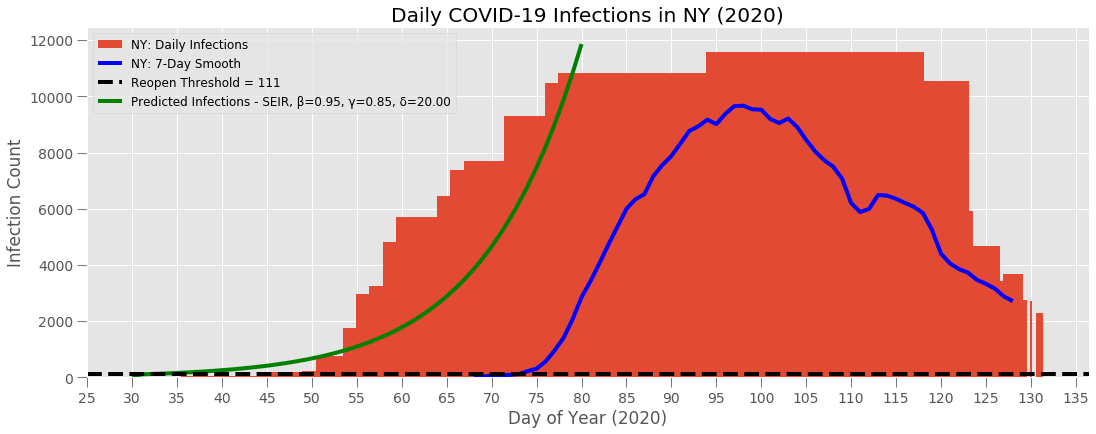

In [36]:
fig, ax = plt.subplots(figsize = (16,6))
for state in states:
    plt.bar(df2.d_o_y, df2['positive_daily_incr'], label = f"{state}: Daily Infections")
    plt.plot(df2.d_o_y, df2['Rolling-{num_days}mean'], label = f"{state}: {num_days}-Day Smooth", color='blue')
    plt.plot(t, I, label = f'Predicted Infections - SEIR, β={beta:.2f}, γ={gamma:.2f}, δ={delta:.2f}', color = 'green')
    ax.axhline(state_reopen_thresh[0], color = 'black', ls="--", label = f"Reopen Threshold = {state_reopen_thresh[0]}")
# ax.set_yscale('log')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(direction='out', length=10)
ax.set_xlabel('Day of Year (2020)')
ax.set_ylabel('Infection Count')
# ax.set_yscale('log')
plt.title(f'Daily COVID-19 Infections in {state} (2020)')
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12,loc='upper left')
plt.show();
fig.savefig('../images/seir_fit_to_NY_infections-01.png', dpi=250)

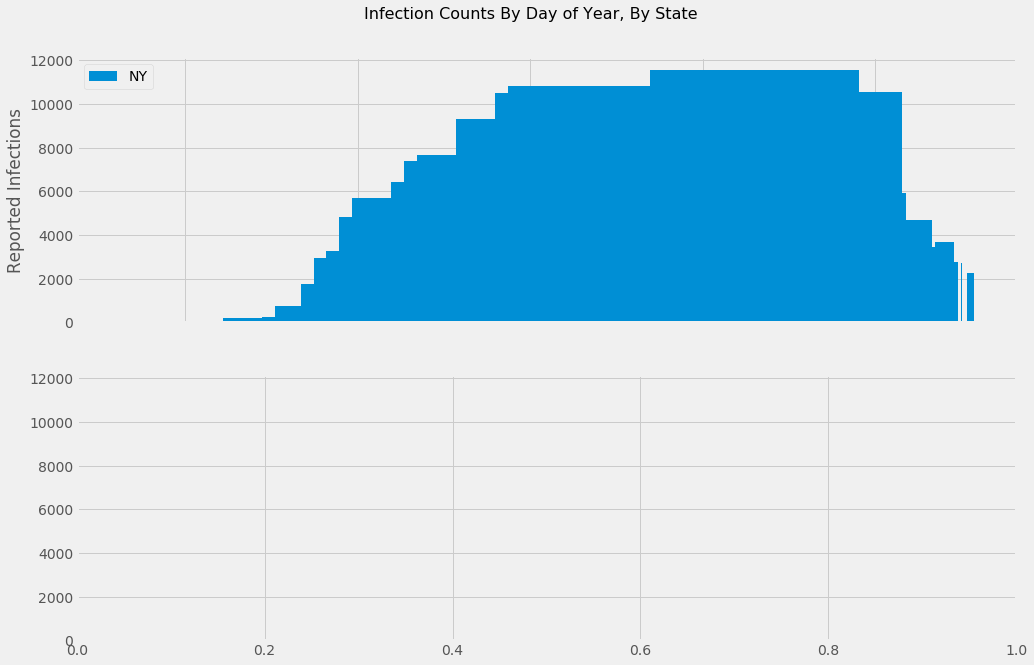

In [22]:
# states = ['CO', 'FL', 'CA', 'MO', 'NY', 'NJ']
fig, axes = plt.subplots(2,1,figsize = (15,10), sharey=True)
for ax, state in zip(axes.flat, states):
    df2 = df_usa[df_usa['state_id']==state]
    ax.bar(df2.d_o_y, df2['positive_daily_incr'], label = f"{state}")
    ax.legend(loc='upper left')
    ax.set_xlabel('Day of Year (2020)') 
    ax.set_ylabel('Reported Infections') 
    ax.label_outer()
plt.suptitle('Infection Counts By Day of Year, By State', fontsize=16, y = 0.95)
plt.show();
fig.savefig("../images/infection_counts_by_doy.png", dpi=125)

In [18]:
df2['positive_daily_incr']

2421    2273.0
2422    2715.0
2423    2758.0
2424    3671.0
2425    2786.0
         ...  
2484      29.0
2485      43.0
2486      11.0
2487      16.0
2488       NaN
Name: positive_daily_incr, Length: 68, dtype: float64

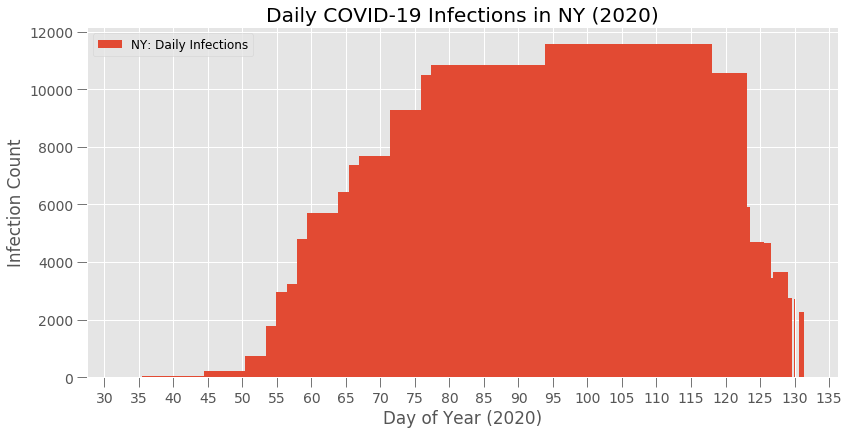

In [44]:
fig, ax = plt.subplots(figsize = (12,6))

for state in states:
    plt.bar(df2.d_o_y, df2['positive_daily_incr'], label = f"{state}: Daily Infections")
    
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(direction='out', length=10)

ax.set_xlabel('Day of Year (2020)')
ax.set_ylabel('Infection Count')

plt.title(f'Daily COVID-19 Infections in {state} (2020)')
plt.legend(fontsize=12,loc='upper left')
plt.show();

In [42]:
df2['positive_daily_incr'].values

array([2.2730e+03, 2.7150e+03, 2.7580e+03, 3.6710e+03, 2.7860e+03,
       2.2390e+03, 2.5380e+03, 3.4380e+03, 4.6630e+03, 3.9420e+03,
       4.6810e+03, 4.5850e+03, 3.1100e+03, 3.9510e+03, 5.9020e+03,
       1.0553e+04, 8.1300e+03, 6.2440e+03, 5.5260e+03, 4.1780e+03,
       4.7260e+03, 6.0540e+03, 7.0900e+03, 7.3580e+03, 8.5050e+03,
       1.1571e+04, 7.1770e+03, 6.3370e+03, 8.2360e+03, 9.9460e+03,
       1.0575e+04, 1.0621e+04, 1.0453e+04, 8.1740e+03, 8.6580e+03,
       8.3270e+03, 1.0841e+04, 1.0482e+04, 8.6690e+03, 7.9170e+03,
       9.2980e+03, 6.9840e+03, 7.1950e+03, 7.6830e+03, 7.3770e+03,
       6.4470e+03, 5.1460e+03, 4.7900e+03, 5.7070e+03, 4.8120e+03,
       3.2540e+03, 2.9500e+03, 1.7700e+03, 6.8200e+02, 7.5000e+02,
       2.2100e+02, 2.0500e+02, 1.0300e+02, 2.0500e+02, 0.0000e+00,
       4.3000e+01, 3.1000e+01, 3.7000e+01, 2.9000e+01, 4.3000e+01,
       1.1000e+01, 1.6000e+01,        nan])

In [39]:
df2.head

<bound method NDFrame.head of        datetime  d_o_y state_name state_id  state_pop_2019  \
2421 2020-05-10  131.0   New York       NY      19453561.0   
2422 2020-05-09  130.0   New York       NY      19453561.0   
2423 2020-05-08  129.0   New York       NY      19453561.0   
2424 2020-05-07  128.0   New York       NY      19453561.0   
2425 2020-05-06  127.0   New York       NY      19453561.0   
...         ...    ...        ...      ...             ...   
2484 2020-03-08   68.0   New York       NY      19453561.0   
2485 2020-03-07   67.0   New York       NY      19453561.0   
2486 2020-03-06   66.0   New York       NY      19453561.0   
2487 2020-03-05   65.0   New York       NY      19453561.0   
2488 2020-03-04   64.0   New York       NY      19453561.0   

      positive_daily_incr  positive_cum  negative_daily_incr  negative_cum  \
2421               2273.0      335395.0              26957.0      847603.0   
2422               2715.0      333122.0              29510.0      820